In [1]:
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('TkAgg')
import numpy as np
import torch.optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import copy

import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch.fft


Bellow is the image deblurring problem generated using FFT

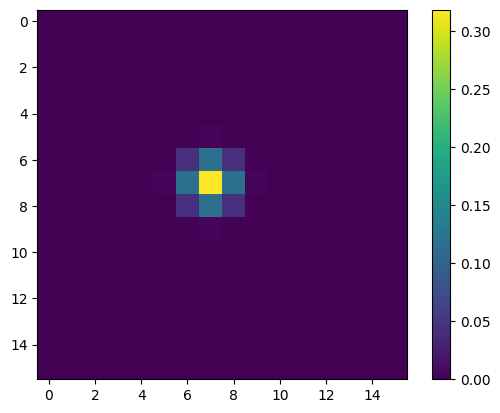

In [23]:
class gaussianConv(nn.Module):
    """
    A PyTorch module that applies a Gaussian convolution to an input image using 
    a parameterized Gaussian Point Spread Function (PSF). The PSF is derived 
    from a covariance matrix and the derivatives of the Gaussian are computed 
    for edge-detection.

    Args:
        C (torch.Tensor): Covariance matrix used to define the shape of the Gaussian.
        t (float, optional): The scaling factor for the Gaussian, default is np.exp(5).
        n0 (float, optional): Scaling factor for the original PSF, default is 1.
        nx (float, optional): Scaling factor for the derivative along the x-axis, default is 1.
        ny (float, optional): Scaling factor for the derivative along the y-axis, default is 1.
    """
    def __init__(self, C, t=np.exp(5), n0=1, nx=1,  ny=1):
        super(gaussianConv, self).__init__()

        self.C  = C
        self.t  = t
        self.n0 = n0
        self.nx = nx
        self.ny = ny

    def forward(self, I):

        P, center = self.psfGauss(I.shape[-1], I.device)

        S = torch.fft.fft2(torch.roll(P, shifts=center, dims=[2,3]))
        B = torch.real(torch.fft.ifft2(S * torch.fft.fft2(I)))

        return B

    def psfGauss(self, dim, device='cpu'):
        # Square conv kenel mxn
        m = dim
        n = dim

        # Create a meshgrid then expand to B,C,X,Y
        x = torch.arange(-m//2+1,m//2+1, device=device)
        y = torch.arange(-n//2+1,n//2+1, device=device)
        X, Y = torch.meshgrid(x,y, indexing='ij')
        X    = X.unsqueeze(0).unsqueeze(0)
        Y    = Y.unsqueeze(0).unsqueeze(0)

        # Use C as inverse covariance matrix
        cx, cy, cxy = self.C[0,0], self.C[1,1], self.C[0,1]

        # Apply gaussian across the mesh
        PSF = torch.exp(-self.t*(cx*X**2 + cy*Y**2 + 2*cxy*X*Y) )
        # Normalize to sum to 1
        PSF0 = PSF / torch.sum(PSF.abs())

        # Derivative kernels over gaussian
        Kdx   = torch.tensor([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])/4
        Kdy   = torch.tensor([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])/4
        Kdx   = Kdx.unsqueeze(0).unsqueeze(0).to(device)
        Kdy   = Kdy.unsqueeze(0).unsqueeze(0).to(device)

        # Perform the convolution to get the derivatives
        PSFdx = F.conv2d(PSF0, Kdx, padding=dim//2)
        PSFdy = F.conv2d(PSF0, Kdy, padding=dim//2)

        PSF = self.n0*PSF0 + self.nx*PSFdx + self.ny*PSFdy
        # Get center ready for output.
        center = [1-m//2, 1-n//2]

        return PSF, center

C = torch.tensor([[1,0],[0, 1]])
A = gaussianConv(C, t=1,n0=1, nx=0,  ny=0)

PSF, _ = A.psfGauss(16)
plt.imshow(PSF[0,0,:,:])
plt.colorbar()



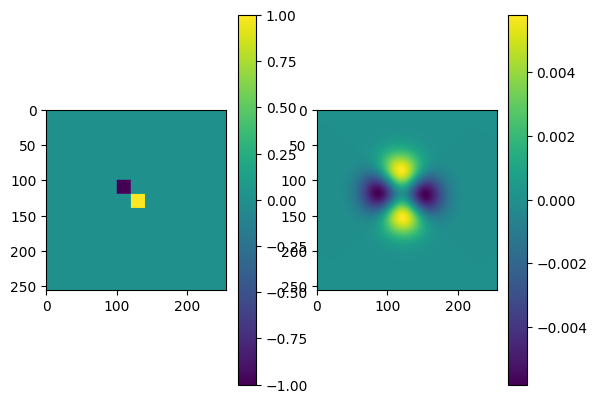

In [3]:
C = torch.tensor([[1, 0],[0, 1]])
A = gaussianConv(C, t=0.001,n0=0, nx=1,  ny=-1)

x = torch.zeros(1, 1, 256, 256)
x[:,:, 120:140, 120:140] = 1.0
x[:,:, 100:120, 100:120] = -1.0


y = A(x)
plt.subplot(1,2,1)
plt.imshow(x[0,0,:,:])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(y[0,0,:,:])
plt.colorbar()
print()


In [47]:
C = torch.tensor([[1, 0],[0, 1]])
Amv = gaussianConv(C, t=0.1,n0=1, nx=0.1,  ny=0.1)

A = torch.zeros(32**2, 32**2)
k = 0
for i in range(32):
  for j in range(32):
    x = torch.zeros(1, 1, 32, 32)
    x[0,0,i,j] = 1

    y = Amv(x)
    y = y.reshape(-1)
    A[:, k] = y
    k = k+1





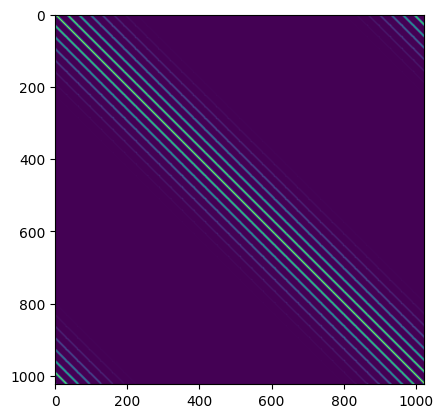

In [48]:

plt.imshow(A)

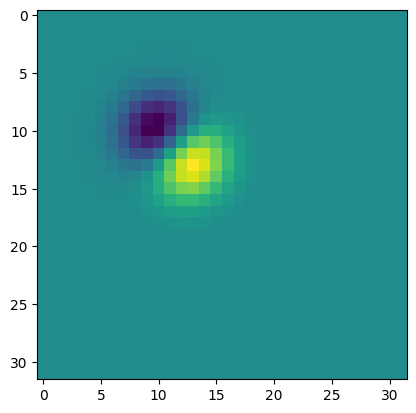

In [49]:
x = torch.zeros(1, 1, 32, 32)
x[:,:, 12:14, 12:14] = 1.0
x[:,:, 10:12, 10:12] = -1.0
b = Amv(x)

plt.imshow(b[0,0,:,:])

In [50]:
U, S, V = torch.linalg.svd(A.to(torch.float64))

tensor(3.1346e-05, dtype=torch.float64)

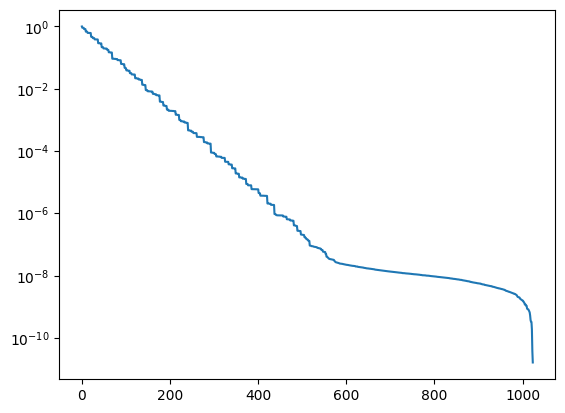

In [51]:
plt.semilogy(S)
F.mse_loss(A , U@ torch.diag(S)@V.t())

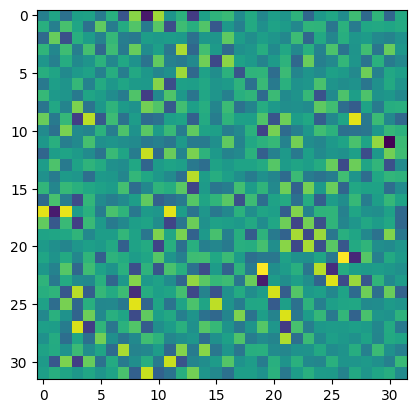

In [52]:
xhat = torch.linalg.solve(A,b.reshape(32**2))
plt.imshow(xhat.reshape([32,32]))


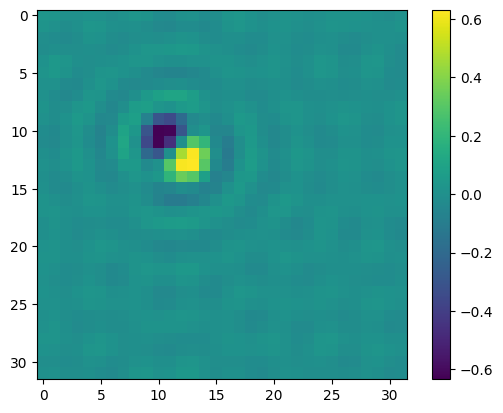

In [64]:
k = 200
Sinv = 1/S
Sinv[k:] = 0

xhat = V.t()@(torch.diag(Sinv)@(U.t()@(b.reshape(32**2).to(torch.float64))))
#plt.imshow(V.t()[:,1].reshape([32,32]))
plt.imshow(xhat.reshape([32,32]))

plt.colorbar()

In [46]:
Sinv

tensor([1.0000, 1.1003, 1.1003,  ..., 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)

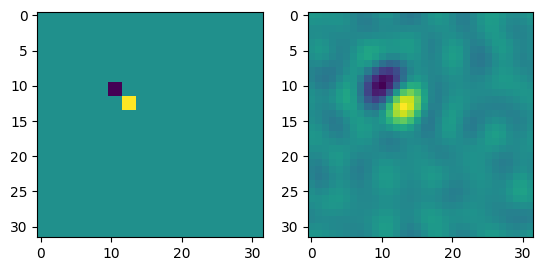

In [65]:
alpha = 0.01
z = torch.randn_like(b)
H = A.t()@A + alpha*torch.eye(1024)
xhat = torch.linalg.solve(H, A.t()@((b+1e-2*z).reshape(32**2)))

plt.subplot(1,2,1)
plt.imshow(x.reshape(32,32))
plt.subplot(1,2,2)
plt.imshow(xhat.reshape(32,32))